<a href="https://colab.research.google.com/github/jorgecif/CovidMisinformationDetection/blob/main/TFM_MIA_ComparacionMetodosClasificacionNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clasificación de la temática de la información** - Comparación de modelos de aprendizaje automático y aprendizaje profundo


> Por: Jorge Orlando Cifuentes Cifuentes




### Librerías y funciones

In [1]:
# Generales
import warnings
warnings.filterwarnings('ignore')
#import csv
#import tensorflow as tf
import pandas as pd
import numpy as np
import joblib # Para exportar el modelo


# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression # Logistic
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.svm import LinearSVC # Support Vector
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM
from keras.layers import Conv1D, MaxPooling1D, Embedding, SpatialDropout1D, Dropout, Activation, Flatten


from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model




In [2]:
# Funciones para comparar modelos

def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc']) # Modifico "acc" por "accuracy"
    plt.plot(history.history['val_acc']) # Modifico "val_acc" por "val_accuracy"
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

# Función para visualizar imagen almacenada en los datos
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

### Carga de datos

In [3]:
# Carga de datos
#url_datos = 'https://raw.githubusercontent.com/jorgecif/TFM_ai_unir/main/Datasets/DatasetNews2020_labels.csv' # 1000 datos por categoría
url_datos = 'https://raw.githubusercontent.com/jorgecif/TFM_ai_unir/main/Datasets/DatasetNews2020_labels10000.csv' # 10000 datos por categoría


datos = pd.read_csv(url_datos) 
datos.columns=["headline", "label"]

# Revuelvo los registros
datos = datos.sample(frac = 1, random_state= 88) 
datos =datos.reset_index()
datos=datos.drop(["index"], axis=1)


# Muestra de los datos 20000 registros
datos=datos.head(20000)


# Muestra de los datos
print(len(datos))
datos.head()


20000


,headline,label
0,Chinese gaming company Beijing Kunlun Tech Co ...,technology
1,The Trump administration on Friday gave five c...,enviroment
2,Poor Larry isn't looking too good. He's pale a...,science
3,BNP Paribas plans to cut 5 percent of the work...,finance
4,Czech Petra Kvitova struggled with unforced er...,sports


In [4]:
# Verifico si hay valores nulos
datos.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  20000 non-null  object
 1   label     20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [5]:
#Elimino duplicados de todas las columnas

datos2 = datos.drop_duplicates()
print(len(datos2))

# Elimino ambiguedades

datos3=datos2.drop_duplicates(['headline'], keep='first') # Elimino ambieguedades
print(len(datos3))

19077
18972


In [6]:
# Desripción de los datos

datos3.describe(include="all")

,headline,label
count,18972,18972
unique,18972,8
top,"Dutch Queen Beatrix, who turns 75 on Thursday,...",technology
freq,1,2934


### Exploración inicial de los datos

In [7]:
# Reviso las 10 primeras categorías de cada variable categórica

for col in datos3.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(datos3[col].value_counts().head(10))

----------------------------------------headline---------------------------------------- - 

Dutch Queen Beatrix, who turns 75 on Thursday, announced she was abdicating in favor of her son, Prince Willem-Alexander, telling her country it was time to hand the crown to the next generation after more than three decades on the throne.                                                              1
The biggest overhaul of the U.S. tax system in more than 30 years, set to win final approval by lawmakers on Wednesday, may add fuel to a rally in technology stocks that has powered Wall Street to record highs this year.                                                                                 1
SoftBank Group Corp Chief Executive Masayoshi Son said on Wednesday he plans to devote the bulk of his time to hunt for technology investments around the world, as part of a major shift in focus at the Japanese tech and telecoms conglomerate.                                                           1
(Adds dropped word to headline, removes extraneous sentence in graf 3, in this Aug. 21 stor

----------------------------------------label---------------------------------------- - 

technology    2934
enviroment    2913
lifestyle     2904
sports        2646
health        2444
politics      2308
science       1913
finance        910
Name: label, dtype: int64

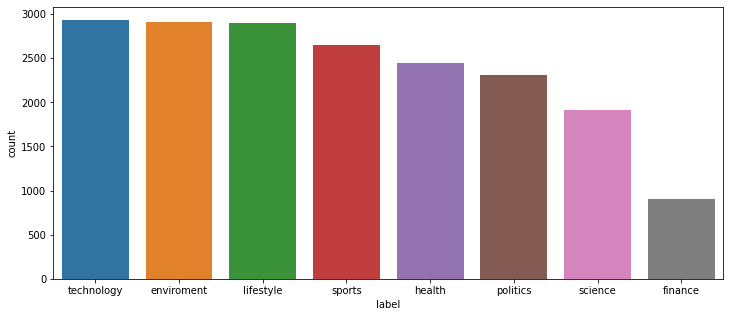

In [8]:
# Distribución de las categorías datos
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos3, order = datos3["label"].value_counts().index)
plt.show()

### Creación conjunto de datos

In [9]:
# Reservo unos datos para pruebas finales (datos que no se tocan)

datos_trabajo,datos_reserva = train_test_split(datos3, test_size=0.05, random_state=88 )
datos_trabajo =datos_trabajo.reset_index() # Reinicio índices
datos_reserva =datos_reserva.reset_index() # Reinicio índices
datos_trabajo=datos_trabajo.drop(["index"], axis=1)
datos_reserva=datos_reserva.drop(["index"], axis=1)

print("Datos para trabajar: ", len(datos_trabajo))
print("Datos reservados para pruebas finales ", len(datos_reserva))



Datos para trabajar:  18023
Datos reservados para pruebas finales  949


In [10]:
datos_reserva.head()

,headline,label
0,(This Aug. 23 story has been corrected to remo...,enviroment
1,The governor of Louisiana and the mayor of New...,enviroment
2,Li Zhongying was freed from a Chinese labor ca...,lifestyle
3,The U.S. State Department said on Sunday it ha...,politics
4,Brazil's President Jair Bolsonaro on Tuesday a...,enviroment


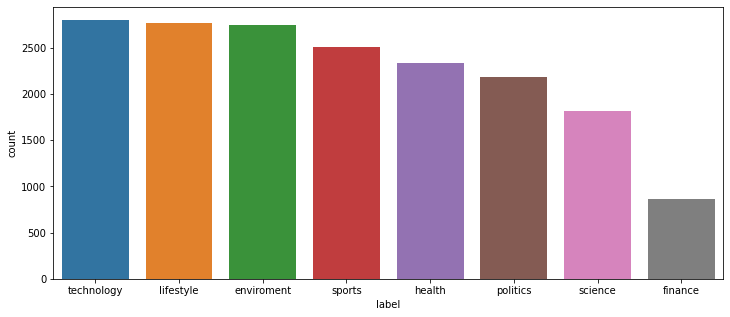

In [11]:
# Distribución de las categorías datos de trabajo
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_trabajo, order = datos_trabajo["label"].value_counts().index)
plt.show()

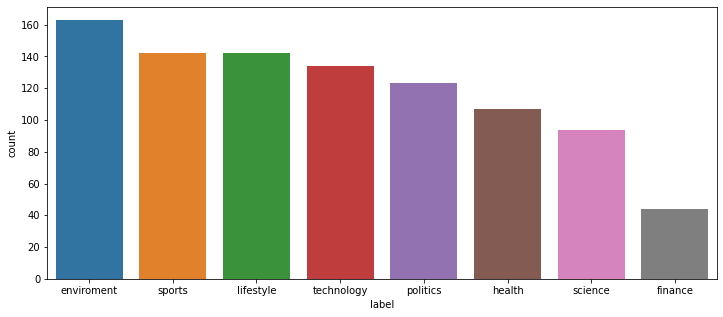

In [12]:
# Distribución de las categorías datos reservados
plt.figure(figsize=(12,5))
sns.countplot("label", data=datos_reserva, order = datos_reserva["label"].value_counts().index)
plt.show()

### Preparación de los datos

In [13]:
# Convierto categorías en números - datos de trabajo

# Extraigo datos de titulares
corpus = datos_trabajo["headline"]
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(corpus).toarray()

# Construyo mapa de categorías datos trabajo
categories = datos_trabajo["label"].unique()
category_dict = {value:index for index, value in enumerate(categories)}
results_trabajo = datos_trabajo["label"].map(category_dict)
category_dict


# Construyo mapa de categorías datos reservados
categories = datos_reserva["label"].unique()
category_dict = {value:index for index, value in enumerate(categories)}
results_reserva = datos_reserva["label"].map(category_dict)
category_dict

{'enviroment': 0,
 'finance': 3,
 'health': 4,
 'lifestyle': 1,
 'politics': 2,
 'science': 7,
 'sports': 6,
 'technology': 5}

In [14]:
category_dict_inv = {v: k for k, v in category_dict.items()}
category_dict_inv

{0: 'enviroment',
 1: 'lifestyle',
 2: 'politics',
 3: 'finance',
 4: 'health',
 5: 'technology',
 6: 'sports',
 7: 'science'}

### Train-test-split

In [15]:
# Train - Test Split

x_train,x_test, y_train,y_test = train_test_split(X, results_trabajo, test_size=0.2, random_state=88 )

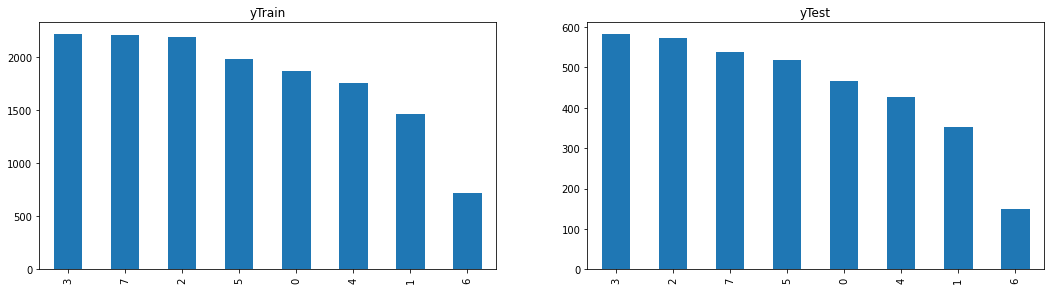

In [16]:
# Visualizo el balance de las clases luego de la división para verificar que no exista un desbalance
df_y_train = pd.DataFrame({'yTrain': y_train})

df_y_test = pd.DataFrame({'yTest': y_test})


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))
plt.subplot(2, 2, 1).set_title('yTrain')
df_y_train["yTrain"].value_counts().plot(kind='bar')

plt.subplot(2, 2, 2).set_title('yTest')
df_y_test["yTest"].value_counts().plot(kind='bar')

### Comparación de modelos de aprendizaje automático

In [17]:
category_dict_inv = {v: k for k, v in category_dict.items()}


In [18]:
category_dict

{'enviroment': 0,
 'finance': 3,
 'health': 4,
 'lifestyle': 1,
 'politics': 2,
 'science': 7,
 'sports': 6,
 'technology': 5}

In [19]:
category_dict_inv

{0: 'enviroment',
 1: 'lifestyle',
 2: 'politics',
 3: 'finance',
 4: 'health',
 5: 'technology',
 6: 'sports',
 7: 'science'}

In [20]:
# Comparación de modelos
# Listado de modelos
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]

In [21]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

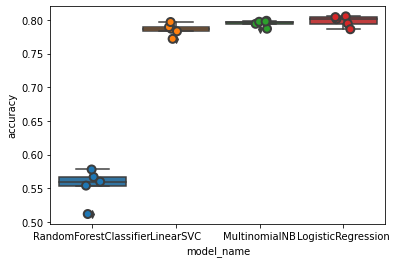

In [22]:
# Gráfico comparativo de la precisión estimada de los modelos
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

#### Modelo Random Forest

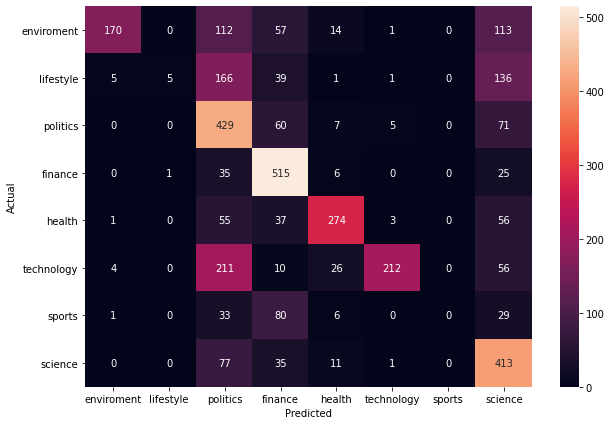

In [23]:
# Modelo RandomForest
from sklearn.metrics import confusion_matrix

modelRF = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
modelRF.fit(x_train, y_train)
y_pred = modelRF.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Modelo Logistic

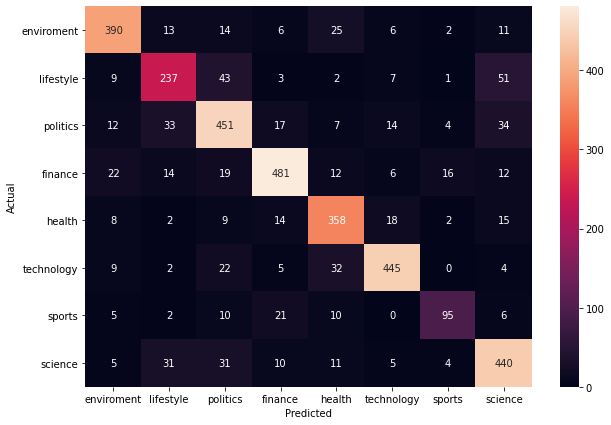

In [24]:
# Modelo Logistic
from sklearn.metrics import confusion_matrix

modelLOG = LogisticRegression(random_state=0)
modelLOG.fit(x_train, y_train)
y_pred = modelLOG.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Modelo Naïve Bayes

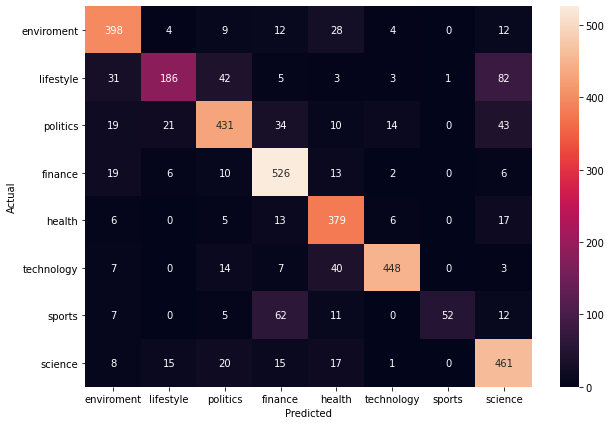

In [25]:
# Modelo Multinomial Naive Bayes
from sklearn.metrics import confusion_matrix

modelNB = MultinomialNB()
modelNB.fit(x_train, y_train)
y_pred = modelNB.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Modelo vector de soporte lineal

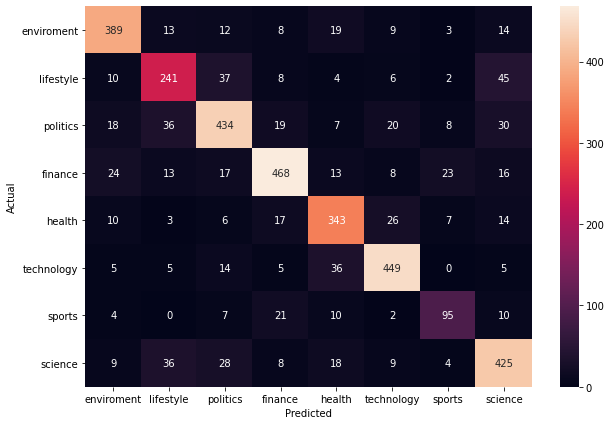

In [26]:
# Modelo Vector Soporte Lineal
from sklearn.metrics import confusion_matrix

modelSVC = LinearSVC()
modelSVC.fit(x_train, y_train)
y_pred = modelSVC.predict(x_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_dict, yticklabels=category_dict)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Prueba de los modelos

In [27]:
# Función para probar modelos y predecir la categoría de la noticia
# De acuerdo con: category_dict_inv[0]

def newscategorifier(a, modelo_probar):
    clf=modelo_probar
    test_name1 = [a]
    transform_vect =vectorizer.transform(test_name1).toarray()
    #print(clf.predict(transform_vect))
    if clf.predict(transform_vect) == 0:
        print(category_dict_inv[0])
    elif clf.predict(transform_vect) == 1:
        print(category_dict_inv[1])
    elif clf.predict(transform_vect) == 2:
        print(category_dict_inv[2])
    elif clf.predict(transform_vect) == 3:
        print(category_dict_inv[3])
    elif clf.predict(transform_vect) == 4:
        print(category_dict_inv[4])    
    elif clf.predict(transform_vect) == 5:
        print(category_dict_inv[5])
    elif clf.predict(transform_vect) == 6:
        print(category_dict_inv[6]) 
    else:
        print(category_dict_inv[7])

In [28]:
# Prueba con textos de datos de reserva

text1=datos_reserva["headline"][0]
text2=datos_reserva["headline"][55]
text3=datos_reserva["headline"][88]

print("Texto 1: ", text1)
print("Categoria real: ",datos_reserva["label"][0])

print("Texto 2: ", text2)
print("Categoria real: ",datos_reserva["label"][55])

print("Texto 3: ", text3)
print("Categoria real: ",datos_reserva["label"][88])

Texto 1:  (This Aug. 23 story has been corrected to remove LVMH, which was not a signatory of the pact)
Categoria real:  enviroment
Texto 2:  Activision Blizzard is betting big on children's fantasy adventure game "Skylanders" this holiday, with the launch of a new title on Sunday and plans for more mobile versions of the console game.
Categoria real:  lifestyle
Texto 3:  Lane Thomas clubbed a two-run homer in the second inning and Justin Williams hit a solo blast later in the frame to help the St. Louis Cardinals post a 7-5 victory over the host Houston Astros on Wednesday at West Palm Beach, Fla.
Categoria real:  sports


In [29]:
# Prueba con los modelos

clasificar_texto=text3

print("Modelo SVC")
print(newscategorifier(clasificar_texto, modelSVC))

print(" ")
print("Modelo NB")
print(newscategorifier(clasificar_texto, modelNB))

print(" ")
print("Modelo LOG")
print(newscategorifier(clasificar_texto, modelLOG))

print(" ")
print("Modelo RF")
print(newscategorifier(clasificar_texto, modelRF))

Modelo SVC
technology
None
 
Modelo NB
technology
None
 
Modelo LOG
technology
None
 
Modelo RF
politics
None


#### Generacion de archivos de modelos

In [30]:
## Guardo los modelos en archivos

filename = 'SVC_model.pkl'
joblib.dump(modelSVC, filename)

filename = 'NB_model.pkl'
joblib.dump(modelNB, filename)

filename = 'LOG_model.pkl'
joblib.dump(modelLOG, filename)

filename = 'RF_model.pkl'
joblib.dump(modelRF, filename)

filename = 'vectorizer.pkl'
joblib.dump(vectorizer, filename)


['vectorizer.pkl']

### Comparación de modelos de aprendizaje profundo

#### Preparación de datos

In [31]:
# Parámetros
n_most_common_words = 8000
max_len = 130

# Creo tokenizador con todos los datos
corpus = datos_trabajo["headline"]
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus.values)
word_index = tokenizer.word_index
print('Se encontraron %s tokens únicos' % len(word_index))

Se encontraron 31078 tokens únicos


In [32]:
# Tokenización datos 

# Trabajo
corpus_trabajo = datos_trabajo["headline"]
sequences = tokenizer.texts_to_sequences(corpus_trabajo.values)
X = pad_sequences(sequences, maxlen=max_len)


# Reserva
corpus_reserva = datos_reserva["headline"]
sequences_reserva = tokenizer.texts_to_sequences(corpus_reserva.values)
X_reserva = pad_sequences(sequences_reserva, maxlen=max_len)

In [33]:
# Categorías

# Categorías datos de trabajo

labels = to_categorical(results_trabajo, num_classes=8)

# Categorías datos reserva

labels_reserva = to_categorical(results_reserva, num_classes=8)

In [34]:
# Train - Test Split

x_train,x_test, y_train,y_test = train_test_split(X, labels, test_size=0.2, random_state=88 )

#### Modelo base inicial

In [35]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 256

In [36]:
# Creación del modelo y compilación

model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_base.summary()

# Compilación

model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 128)          1024000   
_________________________________________________________________
flatten (Flatten)            (None, 16640)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16640)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1065024   
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
Total params: 2,089,544
Trainable params: 2,089,544
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Entrenamiento

history_base = model_base.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])



Epoch 1/20
46/46 [==============================] - 5s 114ms/step - loss: 1.9688 - acc: 0.2251 - val_loss: 1.8203 - val_acc: 0.3818
Epoch 2/20
46/46 [==============================] - 5s 106ms/step - loss: 1.5326 - acc: 0.5573 - val_loss: 1.2942 - val_acc: 0.6491
Epoch 3/20
46/46 [==============================] - 5s 107ms/step - loss: 0.9068 - acc: 0.7578 - val_loss: 0.8898 - val_acc: 0.7188
Epoch 4/20
46/46 [==============================] - 5s 106ms/step - loss: 0.5144 - acc: 0.8542 - val_loss: 0.7532 - val_acc: 0.7559
Epoch 5/20
46/46 [==============================] - 5s 103ms/step - loss: 0.3084 - acc: 0.9254 - val_loss: 0.7046 - val_acc: 0.7843
Epoch 6/20
46/46 [==============================] - 5s 104ms/step - loss: 0.1795 - acc: 0.9688 - val_loss: 0.6958 - val_acc: 0.7850
Epoch 7/20
46/46 [==============================] - 5s 110ms/step - loss: 0.1051 - acc: 0.9873 - val_loss: 0.7046 - val_acc: 0.7864
Epoch 8/20
46/46 [==============================] - 5s 103ms/step - loss: 0.

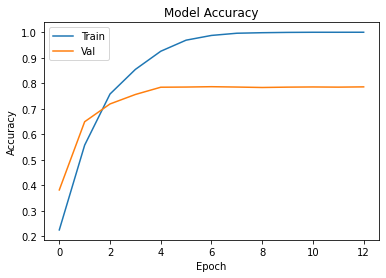

In [38]:
# Resultados

# Accuracy
plot_acc(history_base)

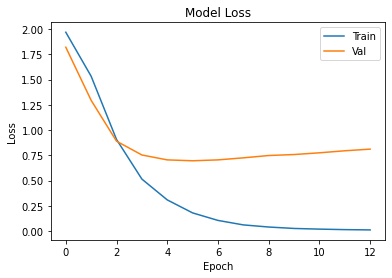

In [39]:
# Loss
plot_loss(history_base)

#### Modelo redes convolucionales - CNN

In [40]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 256

In [41]:
# Creación del modelo y compilación

model_CNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.Conv1D(128, 8, activation='sigmoid'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compilación
model_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
conv1d (Conv1D)              (None, 123, 128)          131200    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
Total params: 1,163,976
Trainable params: 1,163,976
Non-trainable params: 0
____________________________________________

In [42]:
# Entrenamiento

history_CNN = model_CNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/20
46/46 [==============================] - 19s 403ms/step - loss: 2.0752 - acc: 0.1490 - val_loss: 2.0386 - val_acc: 0.1477
Epoch 2/20
46/46 [==============================] - 19s 415ms/step - loss: 2.0386 - acc: 0.1650 - val_loss: 2.0162 - val_acc: 0.2157
Epoch 3/20
46/46 [==============================] - 19s 403ms/step - loss: 1.9844 - acc: 0.2300 - val_loss: 1.9170 - val_acc: 0.3159
Epoch 4/20
46/46 [==============================] - 20s 424ms/step - loss: 1.8320 - acc: 0.3829 - val_loss: 1.7077 - val_acc: 0.5111
Epoch 5/20
46/46 [==============================] - 19s 419ms/step - loss: 1.5970 - acc: 0.4896 - val_loss: 1.4511 - val_acc: 0.6186
Epoch 6/20
46/46 [==============================] - 19s 414ms/step - loss: 1.3199 - acc: 0.6014 - val_loss: 1.2182 - val_acc: 0.6557
Epoch 7/20
46/46 [==============================] - 21s 447ms/step - loss: 1.0649 - acc: 0.6789 - val_loss: 1.0451 - val_acc: 0.6869
Epoch 8/20
46/46 [==============================] - 20s 425ms/step - 

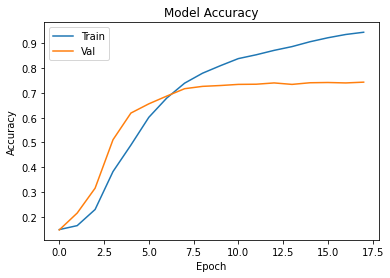

In [43]:
# Resultados

# Accuracy
plot_acc(history_CNN)

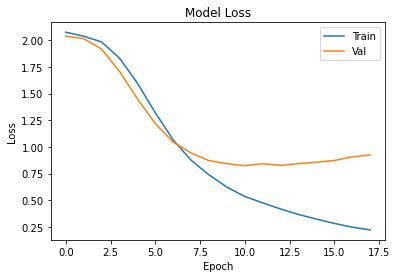

In [44]:
# Loss
plot_loss(history_CNN)

#### Modelo redes recurrentes

In [45]:
# Parámetros de la red
epochs = 20
emb_dim = 128
batch_size = 256

In [46]:
# Creación del modelo y compilación

model_RNN = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.LSTM(64, dropout=0.7, recurrent_dropout=0.7),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model_RNN.summary()

# Compilación

model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 520       
Total params: 1,078,088
Trainable params: 1,078,088
Non-trainable params: 0
____________________________________________

In [47]:
model_RNN = Sequential()
model_RNN.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model_RNN.add(SpatialDropout1D(0.7))
model_RNN.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model_RNN.add(Dense(8, activation='softmax'))
model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model_RNN.summary())
#history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
Total params: 1,073,928
Trainable params: 1,073,928
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
history_RNN = model_RNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Epoch 1/20
46/46 [==============================] - 23s 495ms/step - loss: 2.0459 - acc: 0.1659 - val_loss: 1.9797 - val_acc: 0.2334
Epoch 2/20
46/46 [==============================] - 23s 505ms/step - loss: 1.8733 - acc: 0.2668 - val_loss: 1.6792 - val_acc: 0.3159
Epoch 3/20
46/46 [==============================] - 24s 518ms/step - loss: 1.6624 - acc: 0.3668 - val_loss: 1.5177 - val_acc: 0.4303
Epoch 4/20
46/46 [==============================] - 23s 507ms/step - loss: 1.4507 - acc: 0.4796 - val_loss: 1.1910 - val_acc: 0.6193
Epoch 5/20
46/46 [==============================] - 23s 503ms/step - loss: 1.2116 - acc: 0.5849 - val_loss: 0.9712 - val_acc: 0.6935
Epoch 6/20
46/46 [==============================] - 23s 497ms/step - loss: 1.0488 - acc: 0.6401 - val_loss: 0.9256 - val_acc: 0.6997
Epoch 7/20
46/46 [==============================] - 23s 494ms/step - loss: 0.9399 - acc: 0.6821 - val_loss: 0.8515 - val_acc: 0.7292
Epoch 8/20
46/46 [==============================] - 23s 493ms/step - 

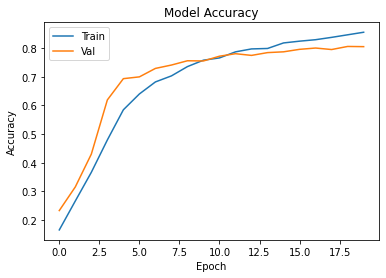

In [49]:
# Resultados

# Accuracy
plot_acc(history_RNN)

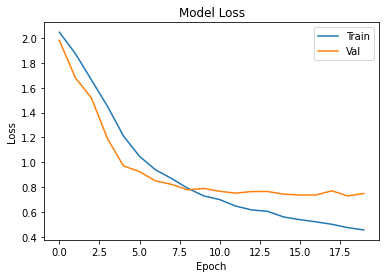

In [50]:
# Loss
plot_loss(history_RNN)

#### Comparación de modelos

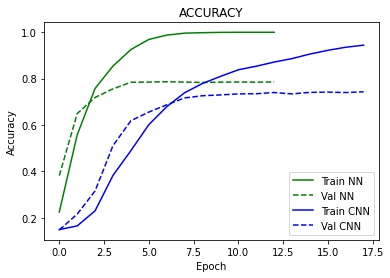

In [51]:
# Comparación NN vs CNN - Accuracy
plot_compare_accs(history_base, history_CNN, 'NN', 'CNN', 'ACCURACY')

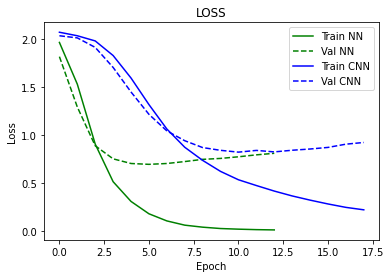

In [52]:
# Comparación NN vs CNN - Loss
plot_compare_losses(history_base, history_CNN, 'NN', 'CNN', 'LOSS')

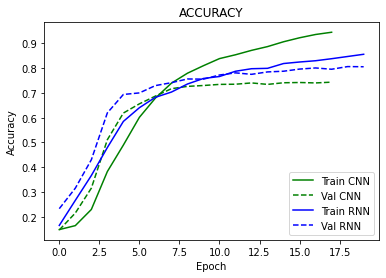

In [53]:
# Comparación CNN vs RNN - Accuracy
plot_compare_accs(history_CNN, history_RNN, 'CNN', 'RNN', 'ACCURACY')

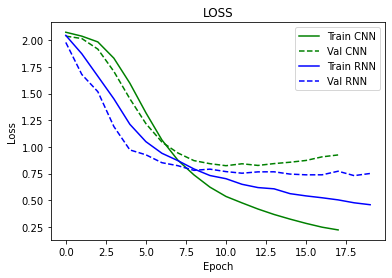

In [54]:
# Comparación CNN vs RNN - Loss
plot_compare_losses(history_CNN, history_RNN, 'CNN', 'RNN', 'LOSS')

#### Prueba de modelos de aprendizaje profundo

In [55]:
# Prueba con textos de datos de reserva

text1=datos_reserva["headline"][120]
text2=datos_reserva["headline"][55]
text3=datos_reserva["headline"][88]

print("Texto 1: ", text1)
print("Categoria real: ",datos_reserva["label"][120])

print("Texto 2: ", text2)
print("Categoria real: ",datos_reserva["label"][55])

print("Texto 3: ", text3)
print("Categoria real: ",datos_reserva["label"][88])

Texto 1:  Refugees in the eastern German town of Jueterbog are sewing face masks for pensioners in a retirement home that has a shortage of facial coverings for elderly residents at heightened risk of coronavirus infection.
Categoria real:  health
Texto 2:  Activision Blizzard is betting big on children's fantasy adventure game "Skylanders" this holiday, with the launch of a new title on Sunday and plans for more mobile versions of the console game.
Categoria real:  lifestyle
Texto 3:  Lane Thomas clubbed a two-run homer in the second inning and Justin Williams hit a solo blast later in the frame to help the St. Louis Cardinals post a 7-5 victory over the host Houston Astros on Wednesday at West Palm Beach, Fla.
Categoria real:  sports


In [56]:
# Función para prueba

def newscategorifier_n(a, modelo_probar):
    clf=modelo_probar
    # Tokenizacion
    corpus_1=[]
    corpus_1.append(a)
    corpus_2=pd.Series(corpus_1)
    sequences_reserva = tokenizer.texts_to_sequences(corpus_2.values)
    transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)
    print(transform_vect_reserva)

    prediccion=clf.predict(transform_vect_reserva)
    prediccion_a = np.array(prediccion)
    print(prediccion_a)    
    indice_max = prediccion_a.argmax()
    print(indice_max)

    if indice_max == 0:
       print(category_dict_inv[0])
    elif indice_max == 1:
       print(category_dict_inv[1])
    elif indice_max == 2:
      print(category_dict_inv[2])
    elif indice_max == 3:
      print(category_dict_inv[3])
    elif indice_max == 4:
      print(category_dict_inv[4])    
    elif indice_max == 5:
      print(category_dict_inv[5])
    elif indice_max == 6:
      print(category_dict_inv[6]) 
    else:
      print(category_dict_inv[7])

In [57]:
# Prueba Única

test=datos_reserva["headline"][120]
  
corpus_t=[]
corpus_t.append(test)
corpus_t=pd.Series(corpus_t)
  
  
sequences_reserva = tokenizer.texts_to_sequences(corpus_t.values)
transform_vect_reserva= pad_sequences(sequences_reserva, maxlen=max_len)

transform_vect_reserva

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7331,
           6,    1,  823,  235,  807,    4,   38, 7330,  336, 1485,    9,
           6,    3, 2232,  193,   12,   18,    3, 2623,    4, 5580, 7805,
           9, 3208,  633,   21, 3810,  324,    4,   30, 1282]],
      dtype=int32)

In [58]:
X_reserva[120]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 7331,
          6,    1,  823,  235,  807,    4,   38, 7330,  336, 1485,    9,
          6,    3, 2232,  193,   12,   18,    3, 2623,    4, 5580, 7805,
          9, 3208,  633,   21, 3810,  324,    4,   30, 1282], dtype=int32)

In [59]:
# Prueba con función

clasificar_texto=text1
print(clasificar_texto)

print("Modelo NN")
print(newscategorifier_n(clasificar_texto, model_base))

print(" ")
print("Modelo CNN")
print(newscategorifier_n(clasificar_texto, model_CNN))

print(" ")
print("Modelo RNN")
print(newscategorifier_n(clasificar_texto, model_RNN))


Refugees in the eastern German town of Jueterbog are sewing face masks for pensioners in a retirement home that has a shortage of facial coverings for elderly residents at heightened risk of coronavirus infection.
Modelo NN
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  7331    6    1  823  235  807    4   38 7330  336 1485    9    6    3
  2232  193   12   18    3 2623    4 5580 7805    9 3208  633   21 3810
   324    4   30 1282]]
[[9.7311121e-01 3.0303029e-03 4.0855519e-03 6.1066862e-04 7.7576563e-03
  6.5478892e-04 2.6072345e-03 8.

#### Generación de archivos de modelos de aprendizaje profundo

In [60]:
## Guardo los modelos en archivos


model_base.save('model_base.h5') 

model_CNN.save('model_CNN.h5') 

model_RNN.save('model_RNN.h5') 